In [18]:
import os
import copy
import numpy as np
from collections import defaultdict


import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# 1. Data Preparation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = "datasets/train"
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# random_split dengan seed
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [8]:
# 2. Model Setup dengan Dropout dan Partial Freezing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze layer sampai layer3
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

# Replace FC dengan Dropout + Linear
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, len(full_dataset.classes))
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
# 3. Training Loop dengan Early Stopping
num_epochs = 20
patience = 5
early_stop_counter = 0

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / val_size
    val_acc = val_corrects.double() / val_size

    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")
        print("Model terbaik disimpan!")
        early_stop_counter = 0  # reset
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping: tidak ada peningkatan dalam {patience} epoch terakhir.")
            break

    scheduler.step()

print(f"\nTraining selesai! Akurasi terbaik: {best_acc:.4f}")


Epoch 1/20
----------
Train Loss: 0.1547 Acc: 0.9341
Val Loss: 0.0672 Acc: 0.9800
Model terbaik disimpan!

Epoch 2/20
----------
Train Loss: 0.0317 Acc: 0.9903
Val Loss: 0.0589 Acc: 0.9800

Epoch 3/20
----------
Train Loss: 0.0200 Acc: 0.9947
Val Loss: 0.0577 Acc: 0.9813
Model terbaik disimpan!

Epoch 4/20
----------
Train Loss: 0.0088 Acc: 0.9978
Val Loss: 0.0599 Acc: 0.9800

Epoch 5/20
----------
Train Loss: 0.0066 Acc: 0.9988
Val Loss: 0.0548 Acc: 0.9775

Epoch 6/20
----------
Train Loss: 0.0053 Acc: 0.9997
Val Loss: 0.0668 Acc: 0.9763

Epoch 7/20
----------
Train Loss: 0.0049 Acc: 0.9984
Val Loss: 0.0807 Acc: 0.9738

Epoch 8/20
----------
Train Loss: 0.0028 Acc: 0.9994
Val Loss: 0.0728 Acc: 0.9788
Early stopping: tidak ada peningkatan dalam 5 epoch terakhir.

Training selesai! Akurasi terbaik: 0.9813


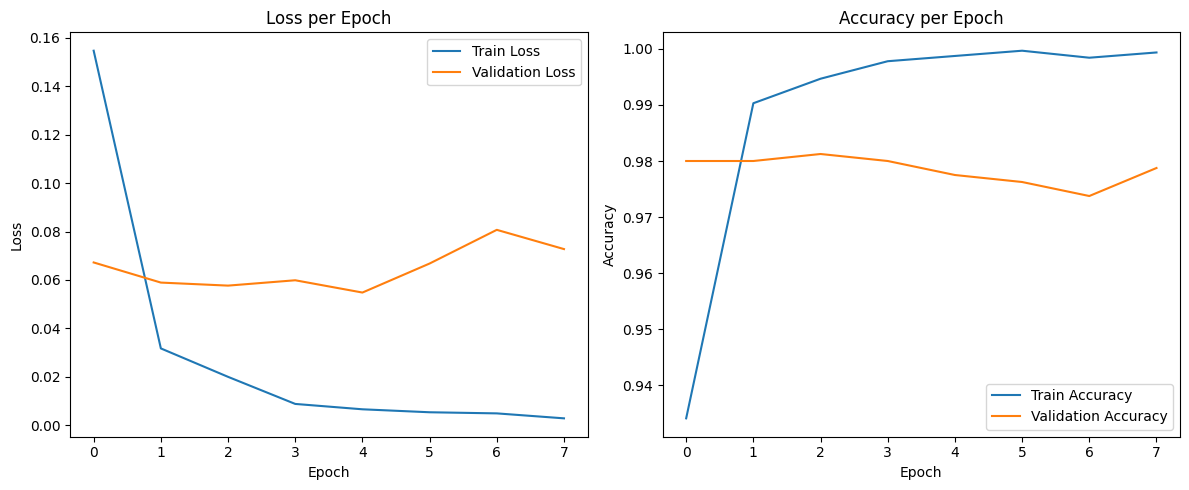

In [ ]:
# Visualisasi Loss dan Accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Ihksan Balany\AppData\Local\Temp\ipykernel_892\3075202910.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


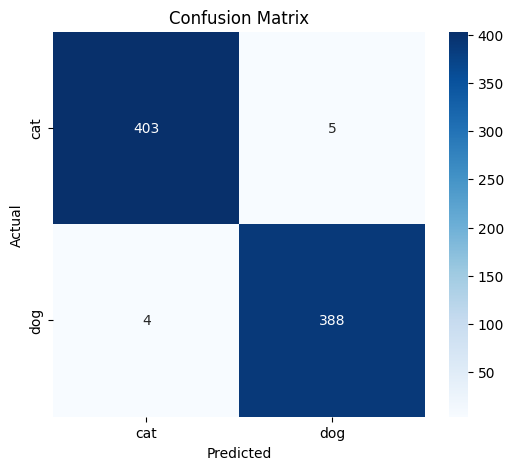

In [16]:
# Aktifkan mode evaluasi
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(inputs.cpu())  # simpan tensor image untuk ditampilkan

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Menampilkan 9 contoh prediksi yang salah:


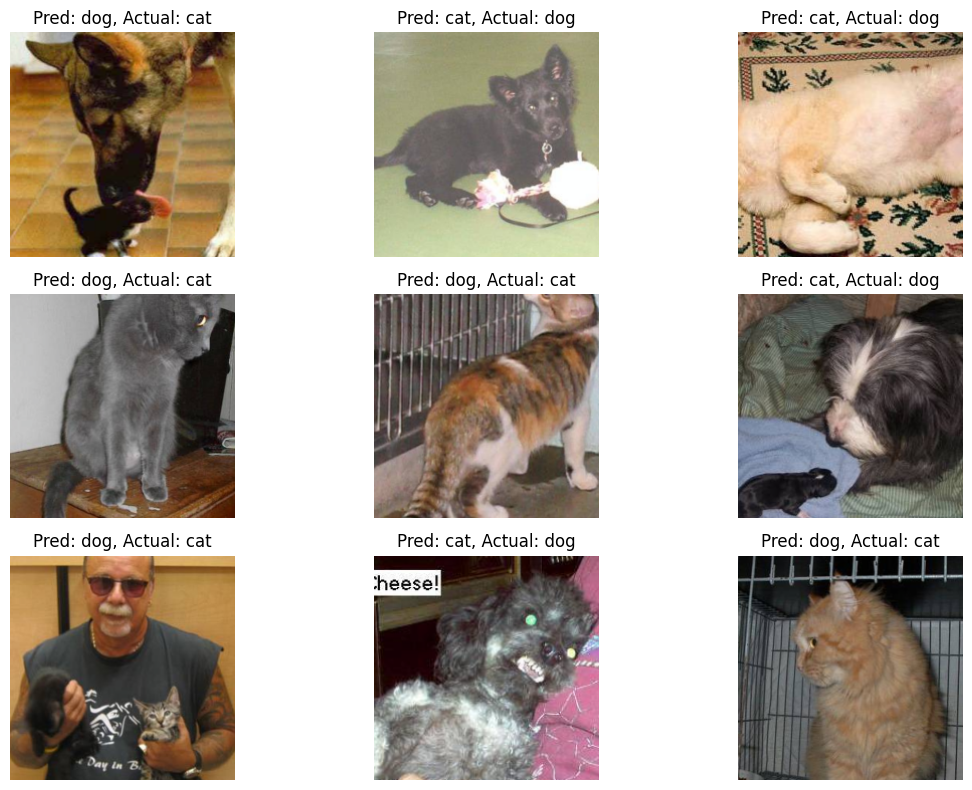

In [19]:
# 2. Tampilkan beberapa contoh yang salah klasifikasi
wrong_indices = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

if wrong_indices:
    print(f"\nMenampilkan {min(9, len(wrong_indices))} contoh prediksi yang salah:")
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(wrong_indices[:9]):
        image = all_images[idx].permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {class_names[all_preds[idx]]}, Actual: {class_names[all_labels[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada prediksi yang salah dalam data validasi.")